In [1]:
import numpy as np

In [2]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import *

from keras.datasets import fashion_mnist, mnist

Using TensorFlow backend.


In [3]:
from utils import *

# Loading and preparing data

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.reshape((x_train.shape[0], -1)).astype(np.float32)
x_test = x_test.reshape((x_test.shape[0], -1)).astype(np.float32)

x_train = x_train / 255.
x_test = x_test / 255.

# Parts definition

In [49]:
BATCH_SIZE = int(0.03 * x_train.shape[0])

INPUT_DIM = x_train.shape[1]
LATENT_DIM = 2
HIDDEN_DIM = 256

### Encoder

In [50]:
inp_encoder_x = Input((INPUT_DIM,))
inp_encoder_noise = Input((LATENT_DIM,))
e = concatenate([inp_encoder_x, inp_encoder_noise])

e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(LATENT_DIM, activation='linear')(e)
           
encoder = Model([inp_encoder_x, inp_encoder_noise], e, name='encoder')

### Decoder

In [51]:
inp_decoder_z = Input((LATENT_DIM,))

d = Dense(HIDDEN_DIM, activation='relu')(inp_decoder_z)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_decoder_z, d, name='decoder')

### Discriminator

In [52]:
inp_adversarial_x = Input((INPUT_DIM,))
inp_adversarial_z = Input((LATENT_DIM,))
a = concatenate([inp_adversarial_x, inp_adversarial_z])

a = GradientReversal()(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(1, activation='sigmoid')(a)

discriminator = Model([inp_adversarial_x, inp_adversarial_z], a, name='discriminator')

## Stacking all together

In [53]:
inp_x = Input((INPUT_DIM,))
inp_noise = Input((LATENT_DIM,))
inp_prior = Input((LATENT_DIM,))

z = encoder([inp_x, inp_noise])
z_adaptive = Lambda(lambda x: (x - K.mean(x, axis=0, keepdims=True)) / K.std(x, axis=0, keepdims=True), name='adaptive_posterior')(z)
x_rec = decoder(z)

discriminator_fake = Lambda(lambda x: x, name='discriminator_fake')(discriminator([inp_x, z]))
discriminator_real = Lambda(lambda x: x, name='discriminator_real')(discriminator([inp_x, inp_prior]))

model = Model([inp_x, inp_noise, inp_prior], [x_rec, discriminator_fake, discriminator_real])
model.compile('adam', 'binary_crossentropy', loss_weights=[INPUT_DIM, LATENT_DIM / 2, LATENT_DIM / 2])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 2)            201986      input_38[0][0]                   
                                                                 input_39[0][0]                   
__________________________________________________________________________________________________
input_40 (InputLayer)           (None, 2)            0                                            
__________

## Training

In [54]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                encoder_noise = np.random.standard_normal((batch_size, LATENT_DIM))
                prior_noise = np.random.standard_normal((batch_size, LATENT_DIM))
                
                yield [X, encoder_noise, prior_noise], [X, zeros, ones]
                
    return generator(), n_steps

In [55]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

In [56]:
model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=32, verbose=2, 
                    callbacks=None, 
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

Epoch 1/32
 - 10s - loss: 325.7195 - decoder_loss: 0.4148 - discriminator_fake_loss: 0.2224 - discriminator_real_loss: 0.2647 - val_loss: 220.8151 - val_decoder_loss: 0.2816 - val_discriminator_fake_loss: 0.0072 - val_discriminator_real_loss: 0.0039
Epoch 2/32
 - 11s - loss: 208.2565 - decoder_loss: 0.2656 - discriminator_fake_loss: 0.0049 - discriminator_real_loss: 0.0049 - val_loss: 199.9262 - val_decoder_loss: 0.2550 - val_discriminator_fake_loss: 0.0042 - val_discriminator_real_loss: 0.0058
Epoch 3/32
 - 10s - loss: 196.3259 - decoder_loss: 0.2504 - discriminator_fake_loss: 0.0042 - discriminator_real_loss: 0.0054 - val_loss: 193.2693 - val_decoder_loss: 0.2465 - val_discriminator_fake_loss: 0.0031 - val_discriminator_real_loss: 0.0047
Epoch 4/32
 - 11s - loss: 191.1145 - decoder_loss: 0.2438 - discriminator_fake_loss: 0.0033 - discriminator_real_loss: 0.0042 - val_loss: 189.0876 - val_decoder_loss: 0.2412 - val_discriminator_fake_loss: 0.0032 - val_discriminator_real_loss: 0.0042


## Visualisation

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

Latent space image

In [58]:
batch = np.concatenate(np.mgrid[-1:1:20j, -1:1:20j].T, axis=0)
z_space_image = decoder.predict(batch).reshape((20, 20, 28, 28))
z_space_image = np.concatenate(z_space_image, axis=-1)
z_space_image = np.concatenate(z_space_image, axis=0)

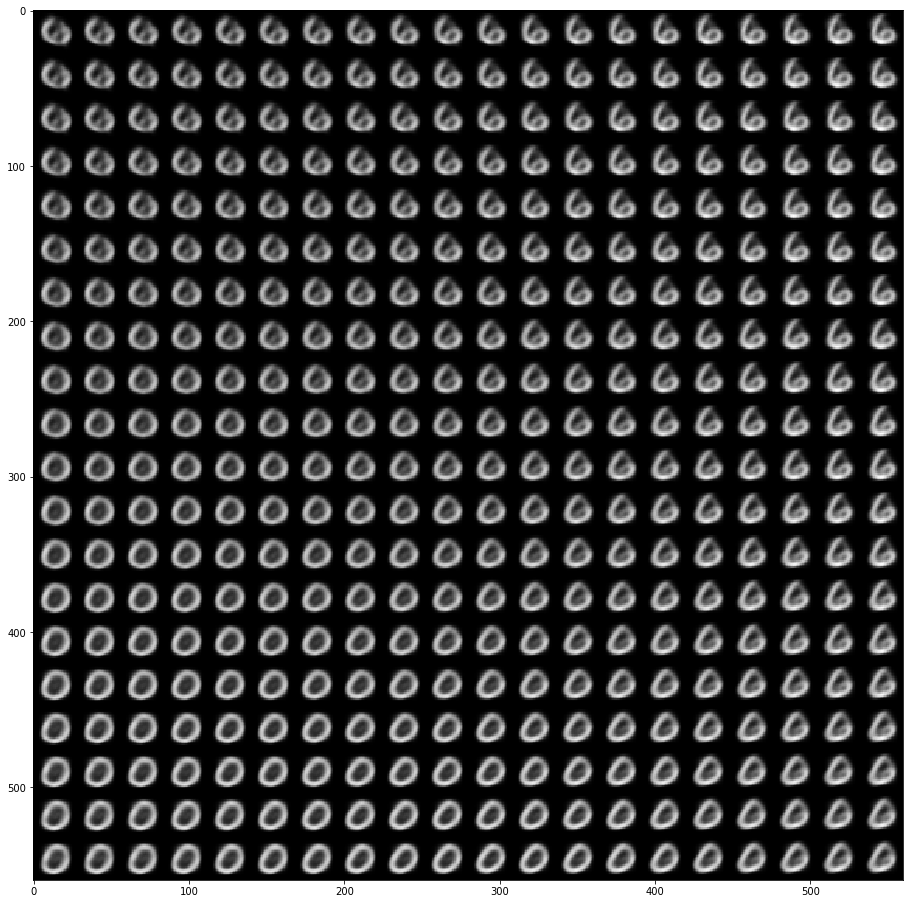

In [59]:
plt.figure(figsize=(16, 16))
plt.imshow(z_space_image, cmap='gray')

Latent space scatter

In [60]:
z_space_code = encoder.predict([x_test, np.random.standard_normal((x_test.shape[0], LATENT_DIM))])
x, y = z_space_code.T

In [61]:
z_space_code.mean(), z_space_code.std()

(-0.7832046, 12.851102)

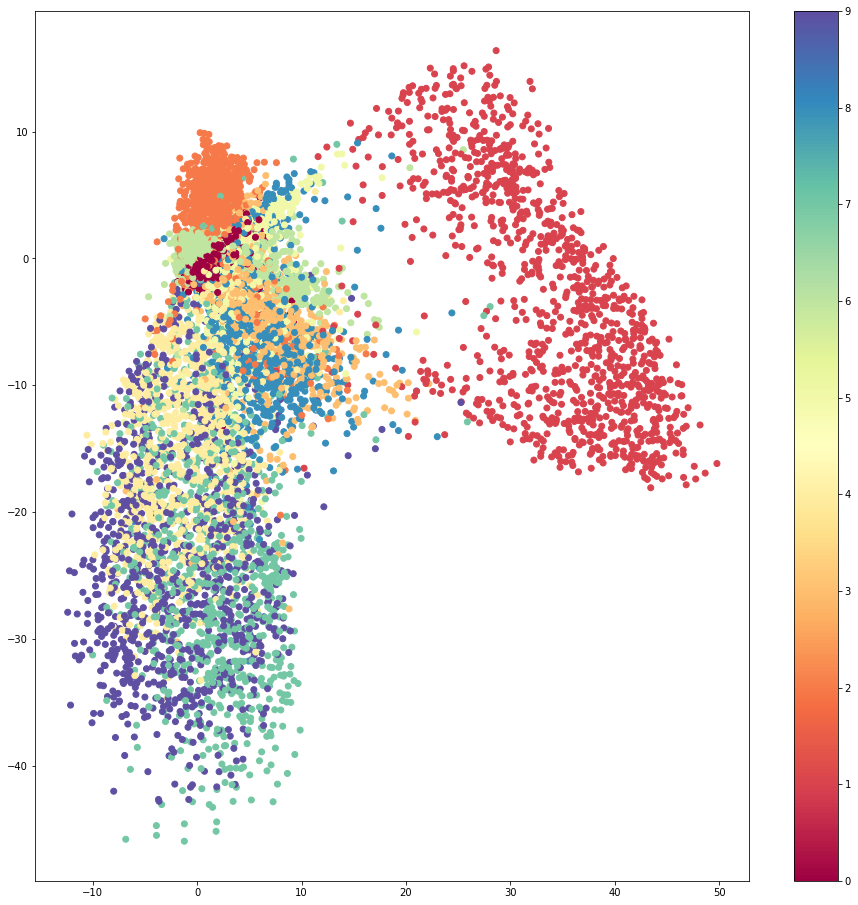

In [62]:
plt.figure(figsize=(16, 16))
plt.scatter(x, y, c=y_test, cmap=plt.cm.Spectral)
plt.colorbar()